In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

from numpyro import render_model
import jax.numpy as jnp


from sklearn.preprocessing import LabelEncoder


import arviz as az

/Users/jackdesmarais/miniconda3/envs/Vakoc_library_analysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('../23.06.29_new_library_design/2024_01_19_experimental_results/DSM_results.xlsx')[['annotation', 'lfc R1','lfc R2']]
df = pd.melt(df, id_vars=['annotation'], value_vars=['lfc R1','lfc R2'])
annotations = df.annotation.str.split('_',expand=True)
annotations = annotations.rename(columns={0:'mut_number', 1:'variant', 2:'version'})
df = pd.concat([df, annotations], axis='columns').dropna()
split_names = df.annotation.str.extract('pt_(?P<position>\d*)(?P<AA>[a-zA-Z\*]*)')
split_names.index = df.index
df = pd.concat([df, split_names], axis='columns').dropna()
df = df.rename(columns={'variable':'replicate', 'value':'LFC'})
df

,annotation,replicate,LFC,mut_number,variant,version,position,AA
0,0pt_WT_v1,lfc R1,0.017191,0pt,WT,v1,,WT
1,0pt_WT_v10,lfc R1,0.367871,0pt,WT,v10,,WT
2,0pt_WT_v100,lfc R1,0.137057,0pt,WT,v100,,WT
3,0pt_WT_v101,lfc R1,-0.299791,0pt,WT,v101,,WT
4,0pt_WT_v102,lfc R1,0.247399,0pt,WT,v102,,WT
...,...,...,...,...,...,...,...,...
11972,1pt_51Y_v1,lfc R2,-0.101883,1pt,51Y,v1,51,Y
11973,1pt_51Y_v2,lfc R2,-1.393591,1pt,51Y,v2,51,Y
11974,1pt_51Y_v3,lfc R2,-2.012110,1pt,51Y,v3,51,Y
11975,1pt_51Y_v4,lfc R2,-1.008160,1pt,51Y,v4,51,Y


In [3]:
replicate_encoder = LabelEncoder()
df["replicate_code"] = replicate_encoder.fit_transform(df["replicate"].values)

variant_encoder = LabelEncoder()
df["variant_code"] = variant_encoder.fit_transform(df["variant"].values)

df

,annotation,replicate,LFC,mut_number,variant,version,position,AA,replicate_code,variant_code
0,0pt_WT_v1,lfc R1,0.017191,0pt,WT,v1,,WT,0,1020
1,0pt_WT_v10,lfc R1,0.367871,0pt,WT,v10,,WT,0,1020
2,0pt_WT_v100,lfc R1,0.137057,0pt,WT,v100,,WT,0,1020
3,0pt_WT_v101,lfc R1,-0.299791,0pt,WT,v101,,WT,0,1020
4,0pt_WT_v102,lfc R1,0.247399,0pt,WT,v102,,WT,0,1020
...,...,...,...,...,...,...,...,...,...,...
11972,1pt_51Y_v1,lfc R2,-0.101883,1pt,51Y,v1,51,Y,1,1019
11973,1pt_51Y_v2,lfc R2,-1.393591,1pt,51Y,v2,51,Y,1,1019
11974,1pt_51Y_v3,lfc R2,-2.012110,1pt,51Y,v3,51,Y,1,1019
11975,1pt_51Y_v4,lfc R2,-1.008160,1pt,51Y,v4,51,Y,1,1019


In [4]:
map_measurement_to_variant = df.variant_code.values

# map_variant_to_replicate = (
#     df[["variant_code", "replicate_code"]]
#     .drop_duplicates()
#     .set_index("variant_code", verify_integrity=True)
#     .sort_index()["replicate_code"]
#     .values
# )
# map_variant_to_replicate

In [46]:
def plot_prior(model, *args, plot_vars=None, log_scale = False, **kwargs):
    display(render_model(model, model_args=args, model_kwargs=kwargs,
                render_distributions=True,
                render_params=True,))

    # prior predictive samples
    pooled_prior_predictive = Predictive(model=model, num_samples=50)
    rng_key = random.PRNGKey(0)
    rng_key, rng_subkey = random.split(rng_key)
    prior_predictive_samples = pooled_prior_predictive(rng_subkey, *args)
    # plot
    if log_scale:
        psuedo = 1
    else:
        psuedo = 0

    label = "prior samples"
    fig, axes = plt.subplots(ncols=len(plot_vars), figsize=(5*len(plot_vars), 5))
    if len(plot_vars) == 1:
        axes = [axes]
    for i, (plot_var, kwarg_key) in enumerate(plot_vars.items()):
        plt.sca(axes[i])
        for n in range(len(prior_predictive_samples[plot_var])):
            to_plot = np.add(prior_predictive_samples[plot_var][n],psuedo)

            if log_scale:
                bins = np.geomspace(min(to_plot),
                                    max(to_plot),
                                        100)
            else:
                bins=100
                            
            plt.hist(
                to_plot,
                bins,
                histtype="step",
                color="k",
                lw=0.5,
                alpha=0.5,
                label=label,
            )
            label = None

        to_plot = np.add(kwargs[kwarg_key],psuedo)
        if log_scale:
            bins = np.geomspace(min(to_plot),
                                max(to_plot),
                                    100)
        else:
            bins=100
        
        plt.hist(to_plot, bins, histtype="step", color="C0", label="data")
        plt.legend()
        plt.ylabel('Count')
        if log_scale:
            plt.xscale('log')
        plt.xlabel(plot_var)
    plt.show()
    return(rng_key)

In [47]:
def run_inference(model, *args, kernel=None, log_scale = False, plot_vars = {'LFC':'LFC_obs'}, **kwargs):
    rng_key = plot_prior(model, *args, plot_vars=plot_vars, log_scale = log_scale, **kwargs)

    mcmc = MCMC(kernel, num_samples=3000, num_warmup=5000)
    mcmc.run(rng_key, *args, **kwargs)

    data = az.from_numpyro(mcmc)
    az.plot_trace(data, compact=True, figsize=(10, 25))
    plt.show()
    
    inf_data = az.from_numpyro(mcmc)
    summary = az.summary(inf_data)
    display(summary)

    # prior predictive samples
    samples = mcmc.get_samples()
    pooled_posterior_predictive = Predictive(model, samples)
    rng_key = random.PRNGKey(0)
    rng_key, rng_subkey = random.split(rng_key)
    posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, *args, )
    # plot

    label = "Posterior samples"
    fig, axes = plt.subplots(ncols=len(plot_vars))
    if len(plot_vars) == 1:
        axes = [axes]
    for i, (plot_var, kwarg_key) in enumerate(plot_vars.items()):
        plt.sca(axes[i])
        _, bins, _ =plt.hist(kwargs[kwarg_key], 100, lw=2, histtype="step", color="C0", label="data")
        for n in np.random.default_rng(0).integers(len(posterior_predictive_samples[plot_var]), size=100):
            plt.hist(
                posterior_predictive_samples[plot_var][n],
                bins,
                histtype="step",
                color="k",
                lw=0.5,
                alpha=0.1,
                label=label,
            )
            label = None

        plt.legend()
        plt.ylabel('Count')
        plt.xlabel(plot_var)
    plt.show()

    return(mcmc, summary)

    
    
    

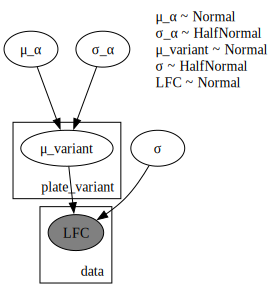

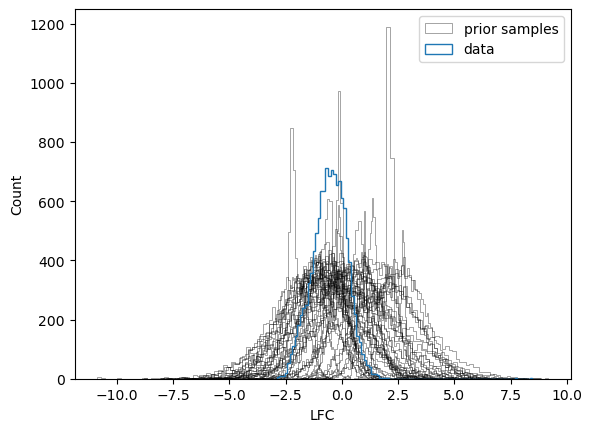

sample: 100%|██████████| 8000/8000 [00:16<00:00, 492.47it/s, 15 steps of size 2.42e-01. acc. prob=0.88]


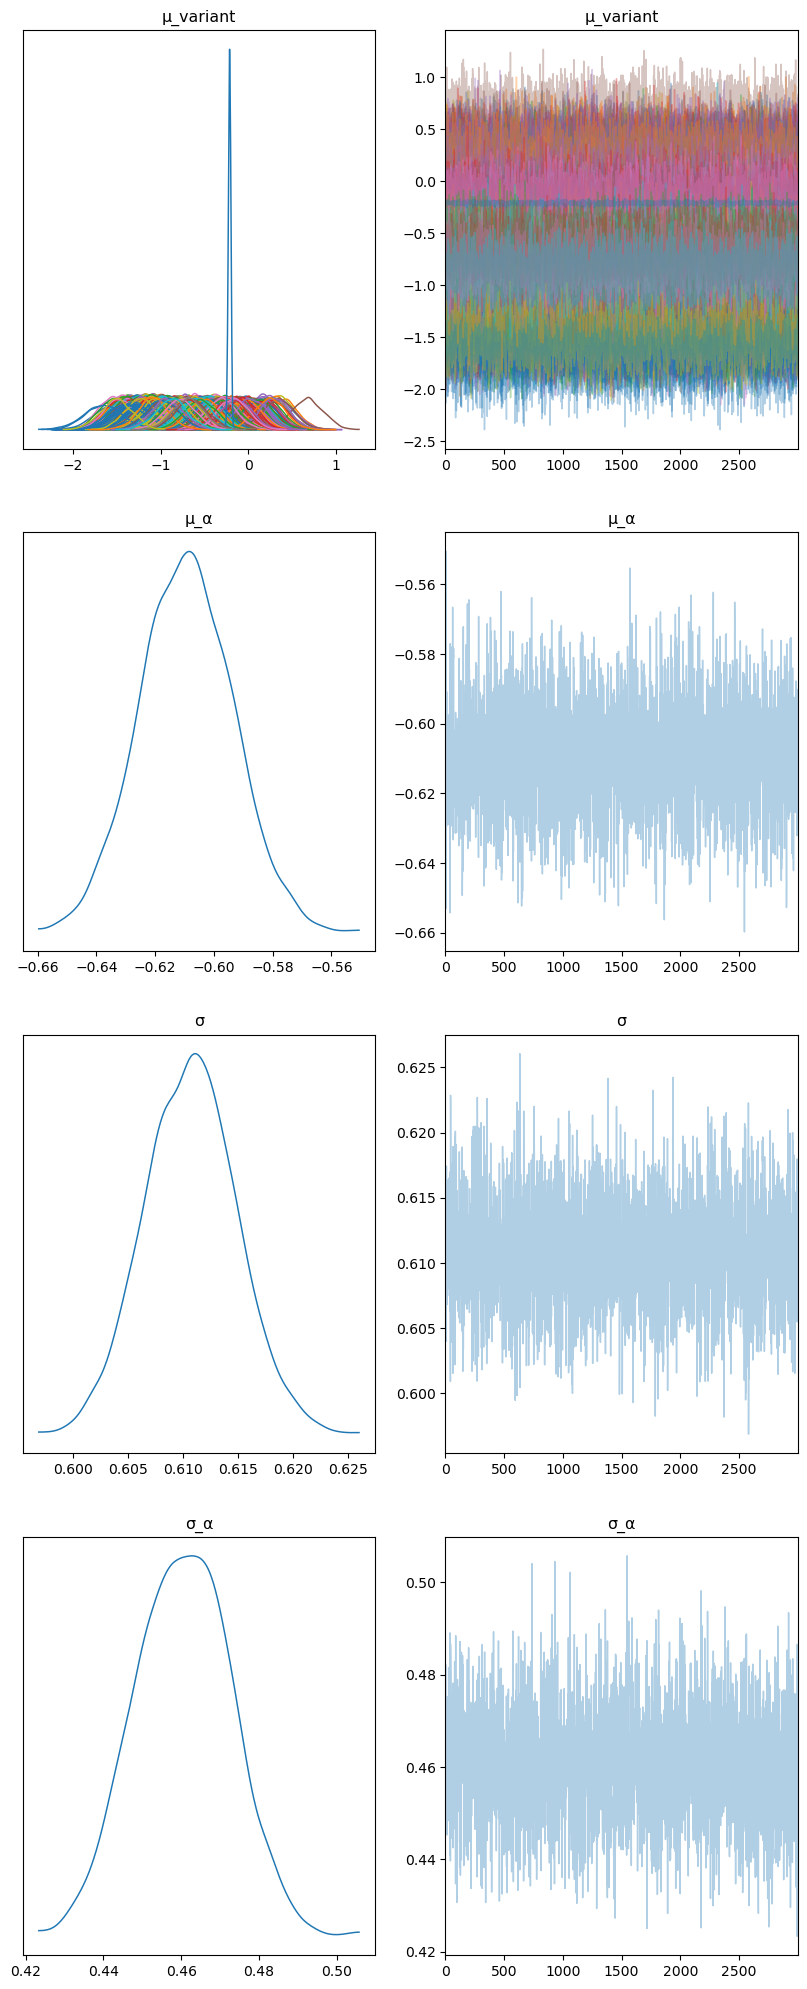

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_variant[0],-1.641,0.213,-2.041,-1.243,0.003,0.002,4823.0,2312.0,NaN
μ_variant[1],-0.908,0.184,-1.239,-0.552,0.003,0.002,4684.0,2711.0,NaN
μ_variant[2],-0.939,0.177,-1.269,-0.607,0.003,0.002,3842.0,2049.0,NaN
μ_variant[3],-0.495,0.177,-0.834,-0.179,0.003,0.002,4079.0,2297.0,NaN
μ_variant[4],-0.721,0.181,-1.038,-0.359,0.003,0.002,4986.0,2152.0,NaN
...,...,...,...,...,...,...,...,...,...
μ_variant[1019],-0.874,0.182,-1.234,-0.536,0.003,0.002,4494.0,2337.0,NaN
μ_variant[1020],-0.211,0.015,-0.238,-0.183,0.000,0.000,4237.0,2023.0,NaN
μ_α,-0.609,0.016,-0.641,-0.581,0.000,0.000,3630.0,2139.0,NaN
σ,0.611,0.004,0.603,0.619,0.000,0.000,3717.0,2239.0,NaN


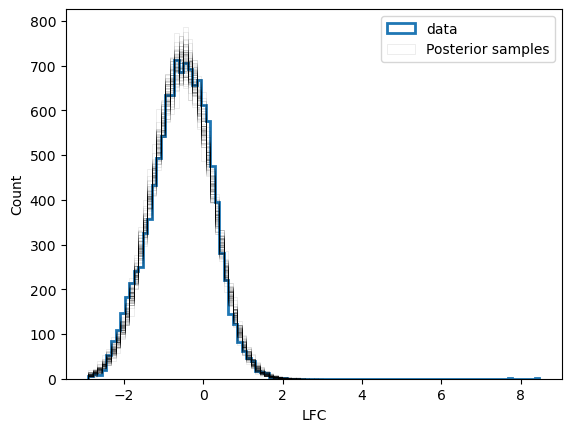

In [7]:
def model_variant(variant_code, LFC_obs=None):
    μ_global = numpyro.sample("μ_α", dist.Normal(0.0, 1.0))
    σ_global = numpyro.sample("σ_α", dist.HalfNormal(1.0))

    n_variants = len(np.unique(variant_code))

    with numpyro.plate("plate_variant", n_variants):
        μ_variant = numpyro.sample(
            "μ_variant",
            dist.Normal(μ_global, σ_global),
        )

    σ = numpyro.sample("σ", dist.HalfNormal(1.0))
    LCF_est = μ_variant[variant_code]
    
    with numpyro.plate("data", len(variant_code)):
        numpyro.sample("LFC", dist.Normal(LCF_est, σ), obs=LFC_obs)



infered, summary = run_inference(model_variant, map_measurement_to_variant, kernel=NUTS(model_variant), LFC_obs = df.LFC.values)

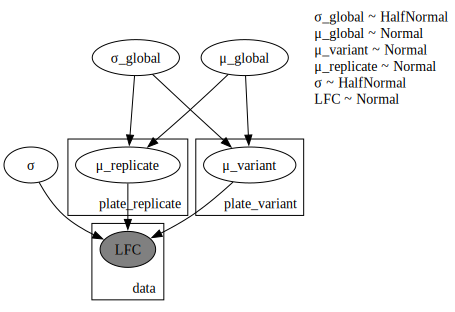

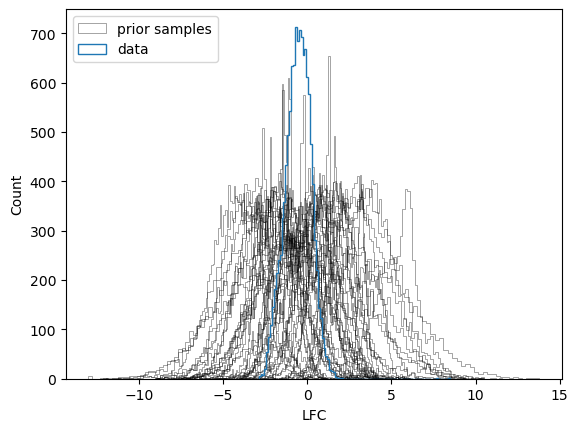

sample: 100%|██████████| 8000/8000 [00:50<00:00, 158.70it/s, 63 steps of size 3.91e-02. acc. prob=0.89] 


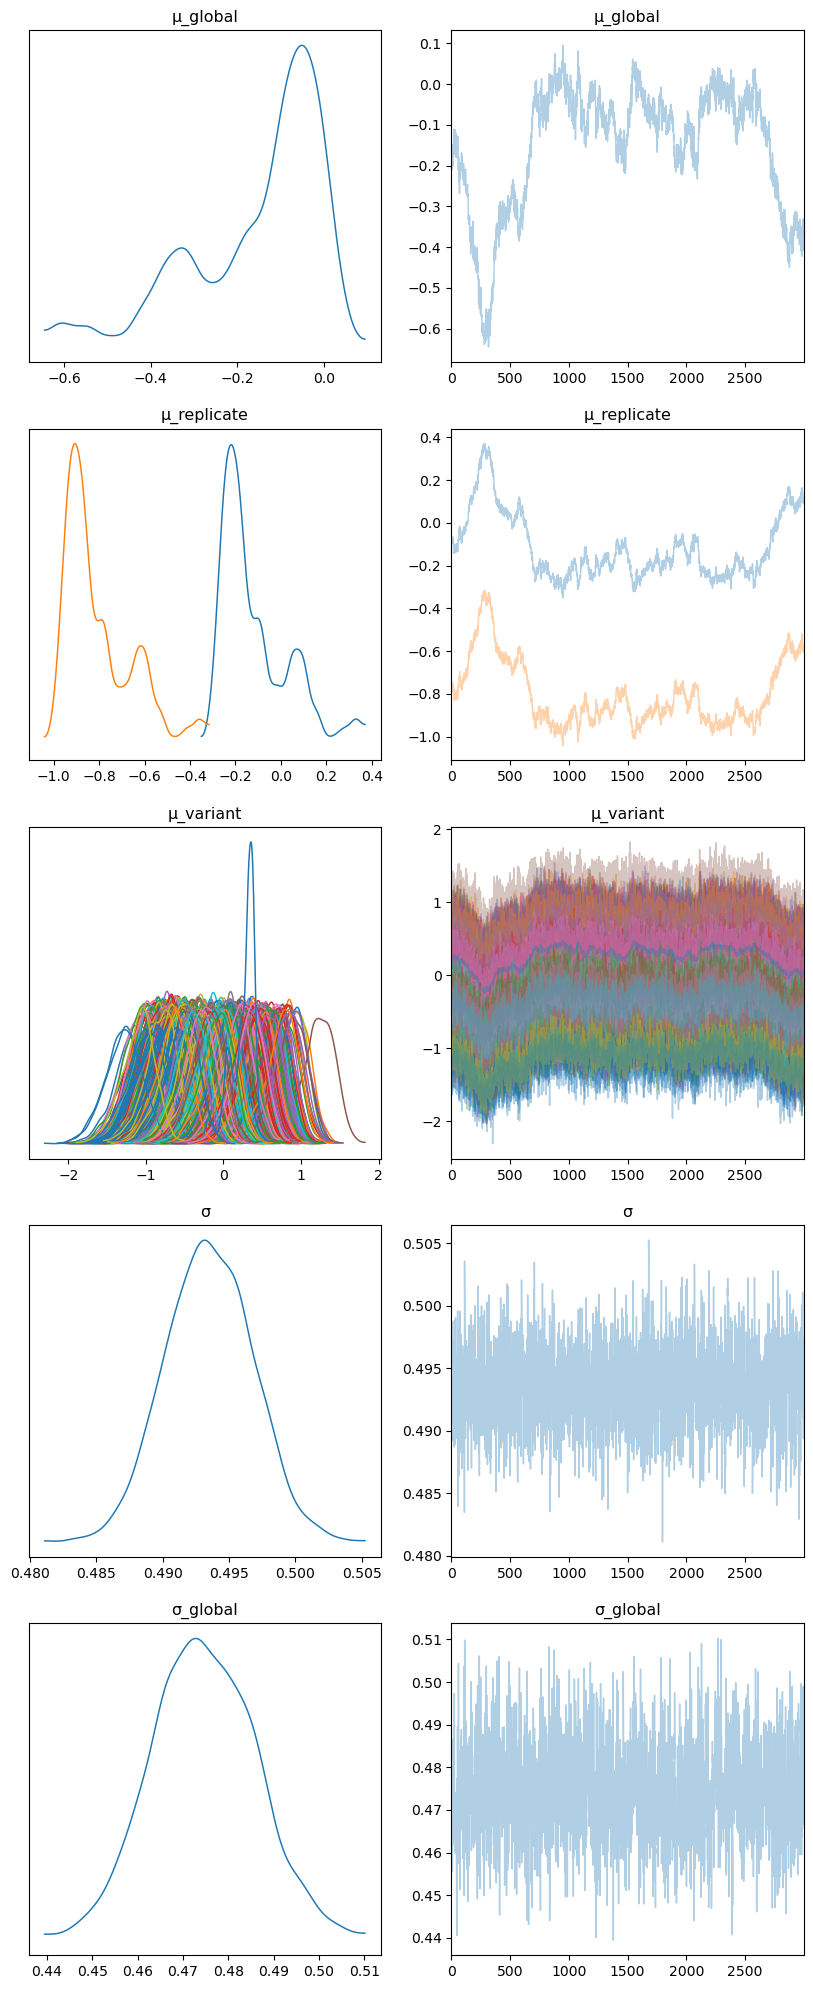

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_global,-0.154,0.153,-0.426,0.056,0.054,0.040,10.0,21.0,NaN
μ_replicate[0],-0.113,0.153,-0.309,0.169,0.054,0.040,10.0,20.0,NaN
μ_replicate[1],-0.801,0.153,-0.993,-0.516,0.054,0.040,10.0,20.0,NaN
μ_variant[0],-1.287,0.235,-1.716,-0.857,0.053,0.039,21.0,74.0,NaN
μ_variant[1],-0.475,0.212,-0.888,-0.122,0.054,0.041,17.0,37.0,NaN
...,...,...,...,...,...,...,...,...,...
μ_variant[1018],-1.102,0.215,-1.506,-0.708,0.055,0.041,17.0,42.0,NaN
μ_variant[1019],-0.436,0.209,-0.858,-0.071,0.052,0.039,17.0,36.0,NaN
μ_variant[1020],0.246,0.153,-0.031,0.455,0.054,0.040,10.0,21.0,NaN
σ,0.493,0.003,0.487,0.499,0.000,0.000,1964.0,2148.0,NaN


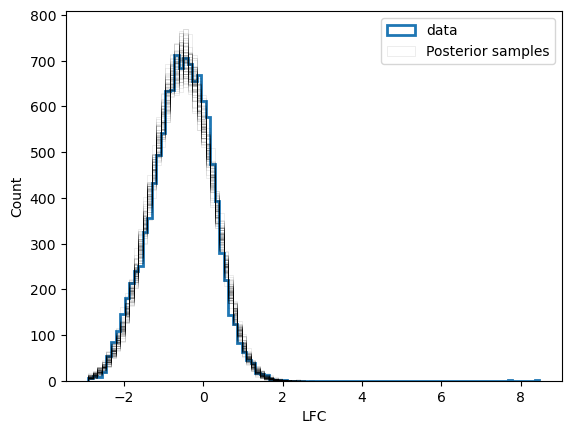

In [11]:
def model_rep_variant(variant_code, replicate_code, LFC_obs=None):
    σ_global = numpyro.sample("σ_global", dist.HalfNormal(1.0))

    μ_global = numpyro.sample("μ_global", dist.Normal(0.0, 1.0))
    

    n_variants = len(np.unique(variant_code))
    n_replicates = len(np.unique(replicate_code))

    variant_plate = numpyro.plate("plate_variant", n_variants)
    replicate_plate = numpyro.plate('plate_replicate', n_replicates)

    with variant_plate:
        μ_variant = numpyro.sample(
            "μ_variant",
            dist.Normal(μ_global, σ_global),
        )

    with replicate_plate:
        μ_replicate = numpyro.sample(
            "μ_replicate",
            dist.Normal(μ_global, σ_global),
        )



    σ = numpyro.sample("σ", dist.HalfNormal(1.0))
    LCF_est = μ_variant[variant_code] + μ_replicate[replicate_code]
    
    with numpyro.plate("data", len(variant_code)):
        numpyro.sample("LFC", dist.Normal(LCF_est, σ), obs=LFC_obs)

infered, summary = run_inference(model_rep_variant, map_measurement_to_variant, df.replicate_code.values, kernel=NUTS(model_rep_variant), LFC_obs = df.LFC.values)

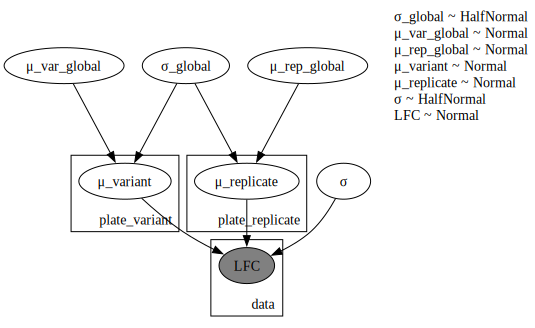

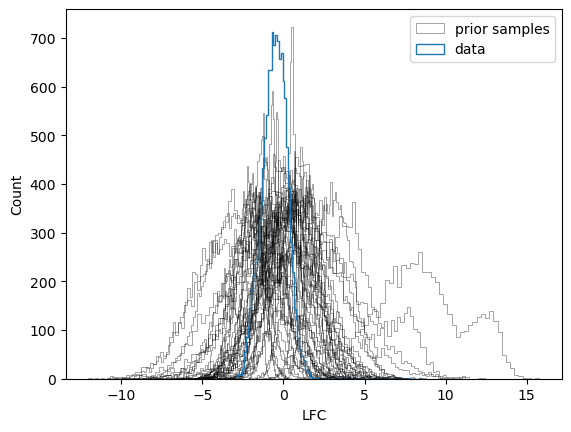

sample: 100%|██████████| 8000/8000 [01:10<00:00, 113.44it/s, 63 steps of size 3.51e-02. acc. prob=0.91] 


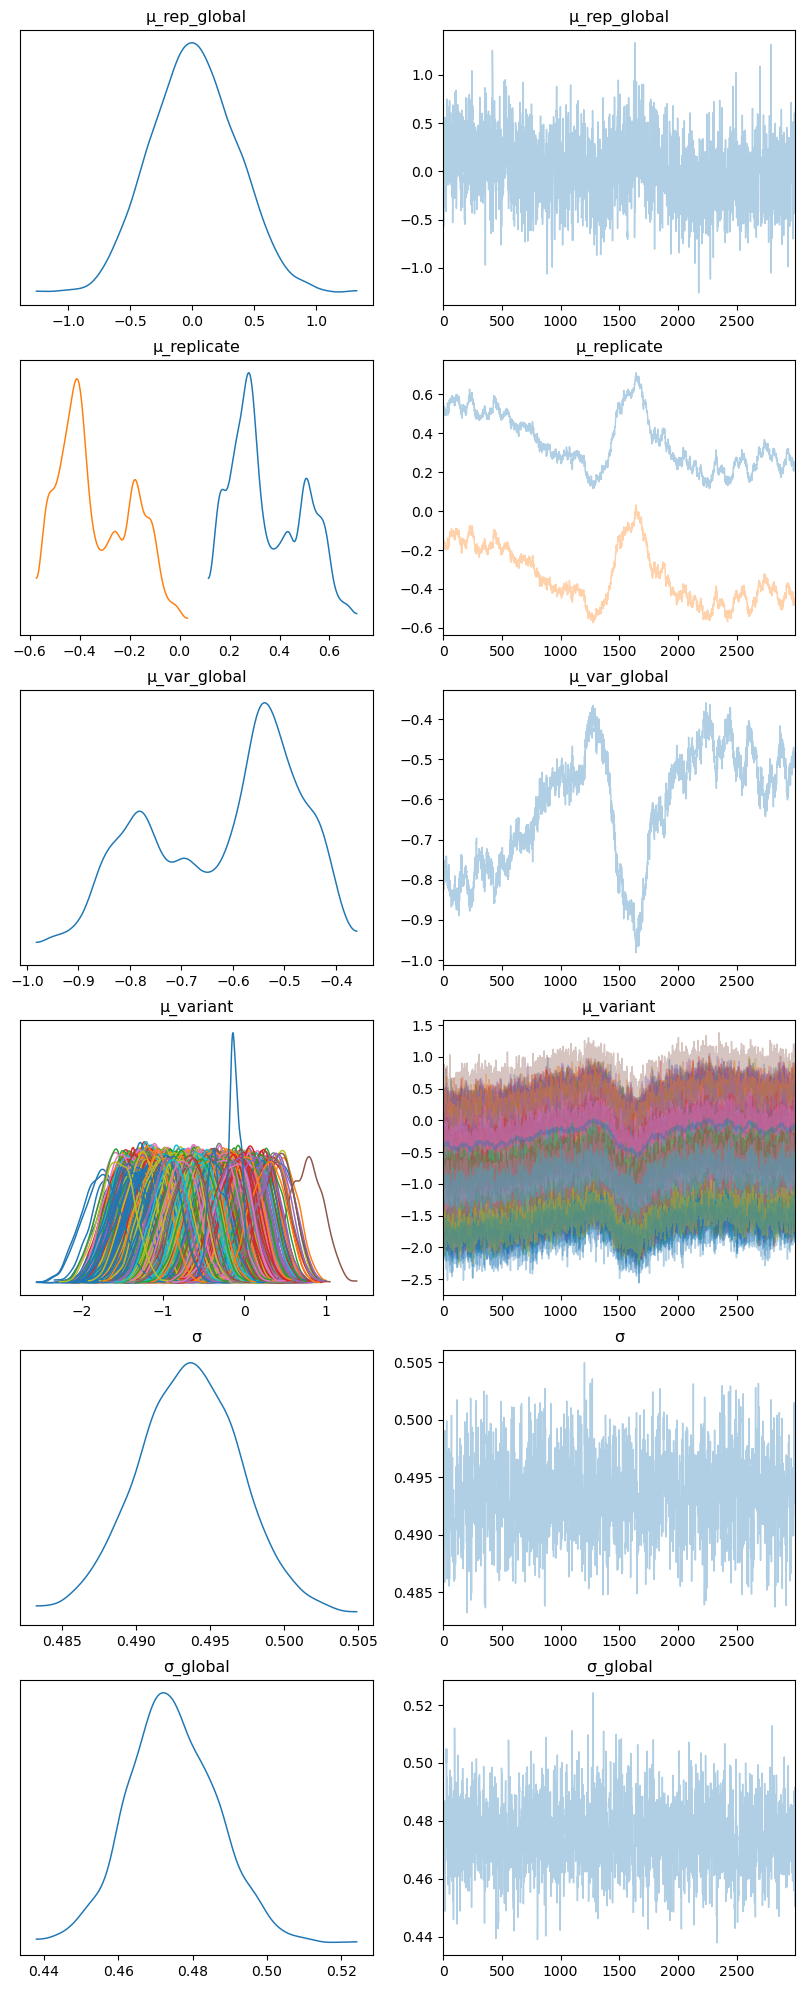

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_rep_global,0.017,0.344,-0.640,0.620,0.041,0.029,70.0,1364.0,NaN
μ_replicate[0],0.354,0.143,0.141,0.594,0.057,0.043,8.0,19.0,NaN
μ_replicate[1],-0.334,0.143,-0.551,-0.097,0.057,0.043,8.0,18.0,NaN
μ_var_global,-0.620,0.144,-0.866,-0.402,0.057,0.043,8.0,22.0,NaN
μ_variant[0],-1.748,0.236,-2.213,-1.339,0.060,0.043,16.0,196.0,NaN
...,...,...,...,...,...,...,...,...,...
μ_variant[1018],-1.570,0.208,-2.000,-1.219,0.059,0.042,13.0,127.0,NaN
μ_variant[1019],-0.906,0.207,-1.280,-0.519,0.059,0.043,12.0,126.0,NaN
μ_variant[1020],-0.220,0.143,-0.464,-0.004,0.057,0.043,8.0,22.0,NaN
σ,0.494,0.003,0.487,0.500,0.000,0.000,1209.0,1868.0,NaN


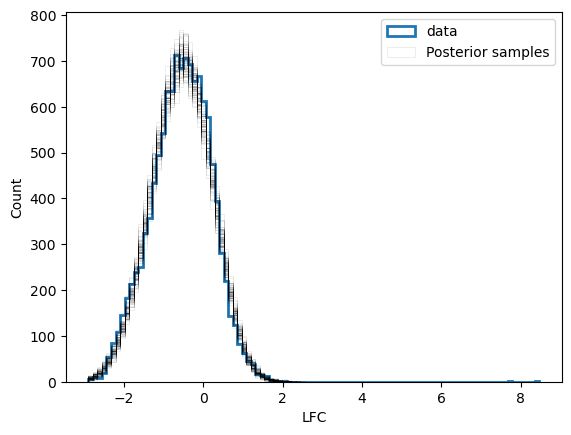

In [21]:
def model_rep_variant(variant_code, replicate_code, LFC_obs=None):
    σ_global = numpyro.sample("σ_global", dist.HalfNormal(1.0))

    μ_var_global = numpyro.sample("μ_var_global", dist.Normal(0.0, 1.0))
    μ_rep_global = numpyro.sample("μ_rep_global", dist.Normal(0.0, 1.0))
    

    n_variants = len(np.unique(variant_code))
    n_replicates = len(np.unique(replicate_code))

    variant_plate = numpyro.plate("plate_variant", n_variants)
    replicate_plate = numpyro.plate('plate_replicate', n_replicates)

    with variant_plate:
        μ_variant = numpyro.sample(
            "μ_variant",
            dist.Normal(μ_var_global, σ_global),
        )

    with replicate_plate:
        μ_replicate = numpyro.sample(
            "μ_replicate",
            dist.Normal(μ_rep_global, σ_global),
        )



    σ = numpyro.sample("σ", dist.HalfNormal(1.0))
    LCF_est = μ_variant[variant_code] + μ_replicate[replicate_code]
    
    with numpyro.plate("data", len(variant_code)):
        numpyro.sample("LFC", dist.Normal(LCF_est, σ), obs=LFC_obs)

infered, summary = run_inference(model_rep_variant, map_measurement_to_variant, df.replicate_code.values, kernel=NUTS(model_rep_variant), LFC_obs = df.LFC.values)

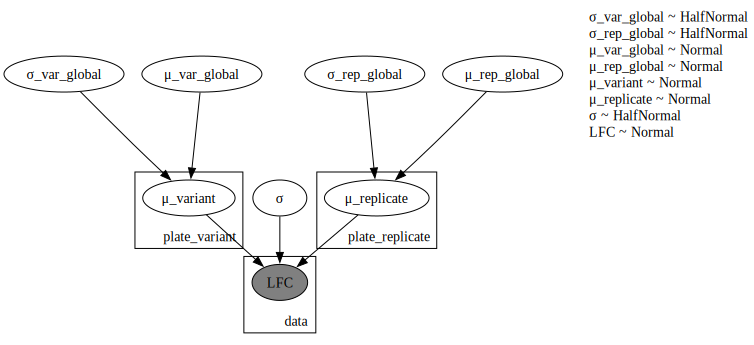

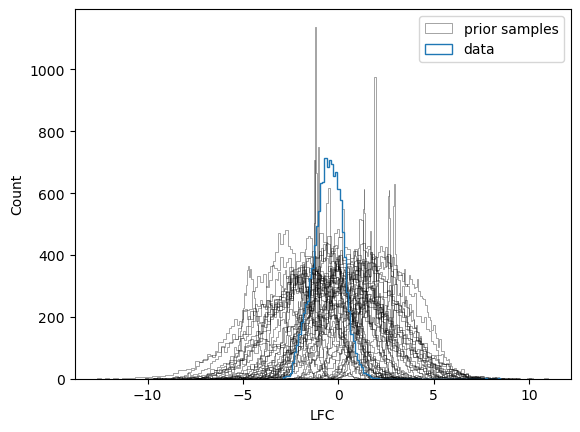

sample: 100%|██████████| 8000/8000 [01:37<00:00, 82.35it/s, 127 steps of size 2.00e-02. acc. prob=0.91] 


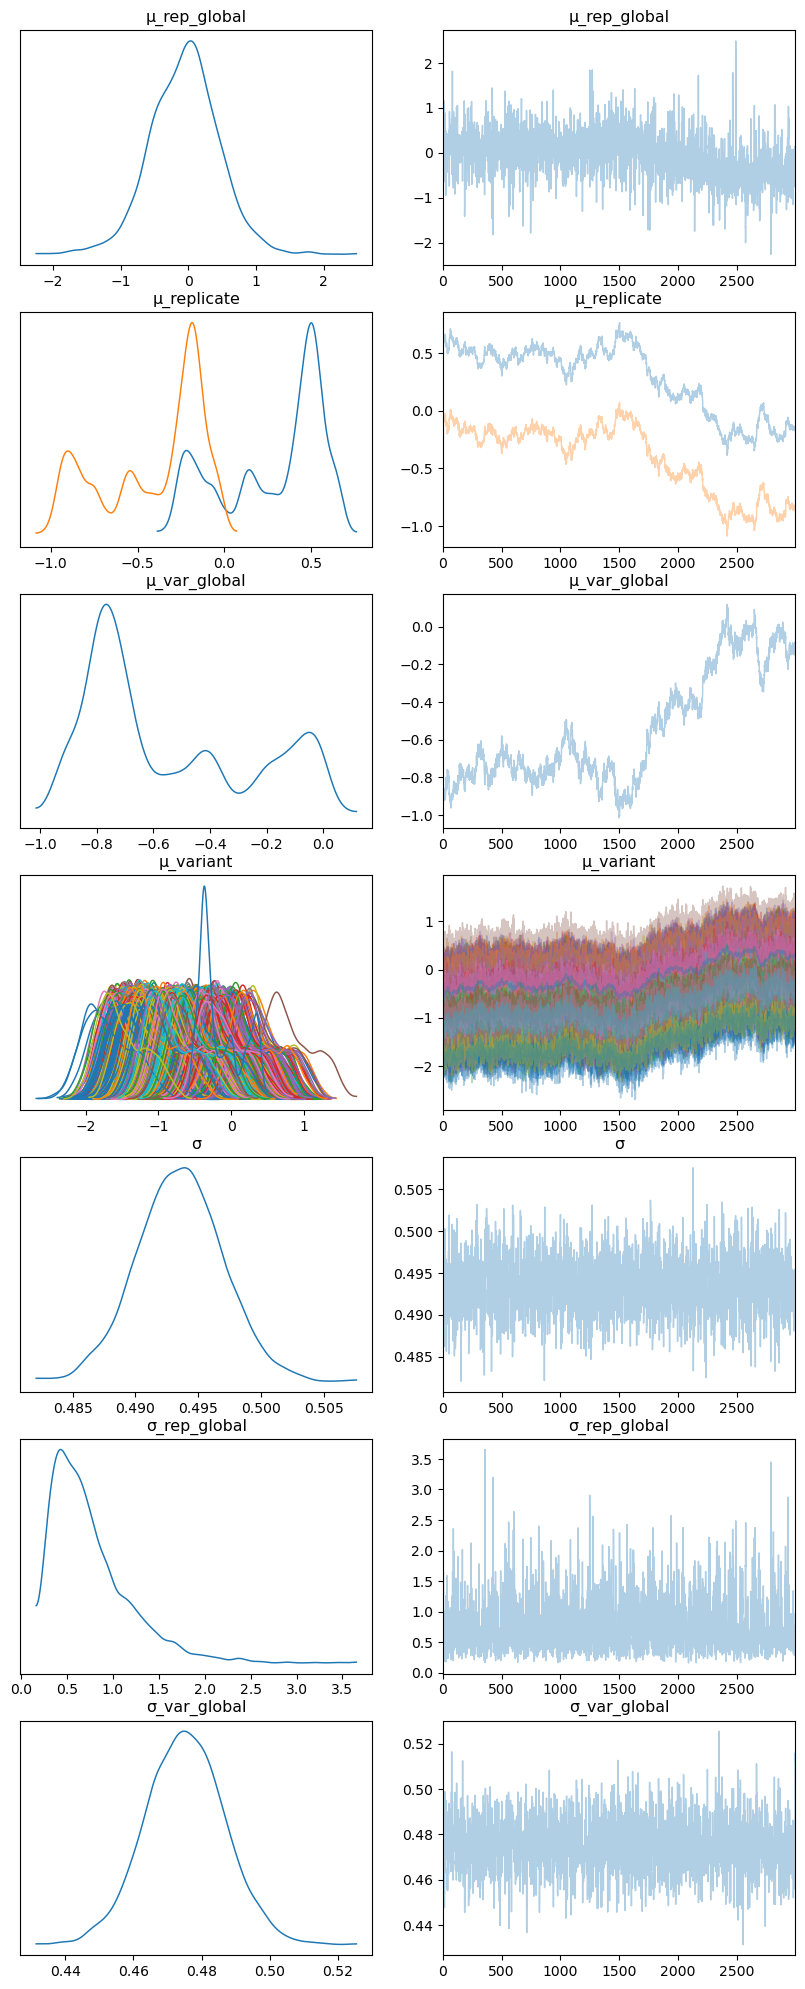

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_rep_global,-0.054,0.511,-0.973,0.920,0.216,0.162,5.0,67.0,NaN
μ_replicate[0],0.279,0.297,-0.267,0.642,0.240,0.220,2.0,51.0,NaN
μ_replicate[1],-0.409,0.297,-0.948,-0.040,0.240,0.220,2.0,49.0,NaN
μ_var_global,-0.544,0.297,-0.907,0.005,0.240,0.219,2.0,52.0,NaN
μ_variant[0],-1.679,0.350,-2.254,-1.026,0.249,0.212,2.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...
μ_variant[1019],-0.830,0.332,-1.339,-0.193,0.247,0.215,2.0,14.0,NaN
μ_variant[1020],-0.145,0.297,-0.512,0.399,0.240,0.220,2.0,49.0,NaN
σ,0.494,0.003,0.487,0.500,0.000,0.000,1863.0,1989.0,NaN
σ_rep_global,0.753,0.427,0.181,1.538,0.011,0.008,1525.0,2052.0,NaN


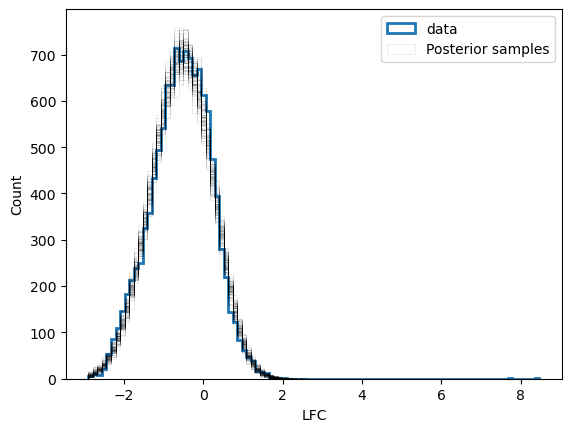

In [12]:
def model_rep_variant(variant_code, replicate_code, LFC_obs=None):
    σ_var_global = numpyro.sample("σ_var_global", dist.HalfNormal(1.0))
    σ_rep_global = numpyro.sample("σ_rep_global", dist.HalfNormal(1.0))

    μ_var_global = numpyro.sample("μ_var_global", dist.Normal(0.0, 1.0))
    μ_rep_global = numpyro.sample("μ_rep_global", dist.Normal(0.0, 1.0))
    

    n_variants = len(np.unique(variant_code))
    n_replicates = len(np.unique(replicate_code))

    variant_plate = numpyro.plate("plate_variant", n_variants)
    replicate_plate = numpyro.plate('plate_replicate', n_replicates)

    with variant_plate:
        μ_variant = numpyro.sample(
            "μ_variant",
            dist.Normal(μ_var_global, σ_var_global),
        )

    with replicate_plate:
        μ_replicate = numpyro.sample(
            "μ_replicate",
            dist.Normal(μ_rep_global, σ_rep_global),
        )



    σ = numpyro.sample("σ", dist.HalfNormal(1.0))
    LCF_est = μ_variant[variant_code] + μ_replicate[replicate_code]
    
    with numpyro.plate("data", len(variant_code)):
        numpyro.sample("LFC", dist.Normal(LCF_est, σ), obs=LFC_obs)

infered, summary = run_inference(model_rep_variant, map_measurement_to_variant, df.replicate_code.values, kernel=NUTS(model_rep_variant), LFC_obs = df.LFC.values)

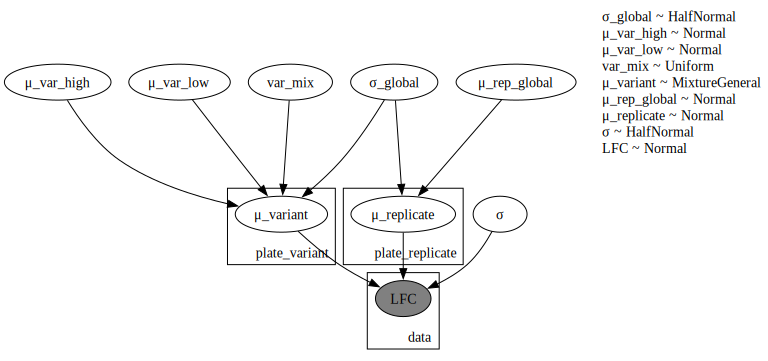

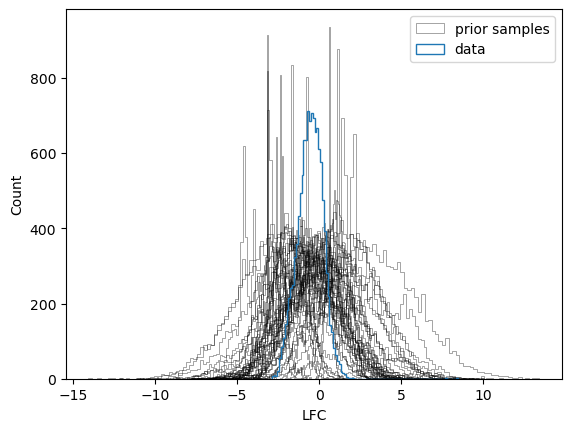

sample: 100%|██████████| 8000/8000 [01:39<00:00, 80.70it/s, 127 steps of size 2.17e-02. acc. prob=0.90] 


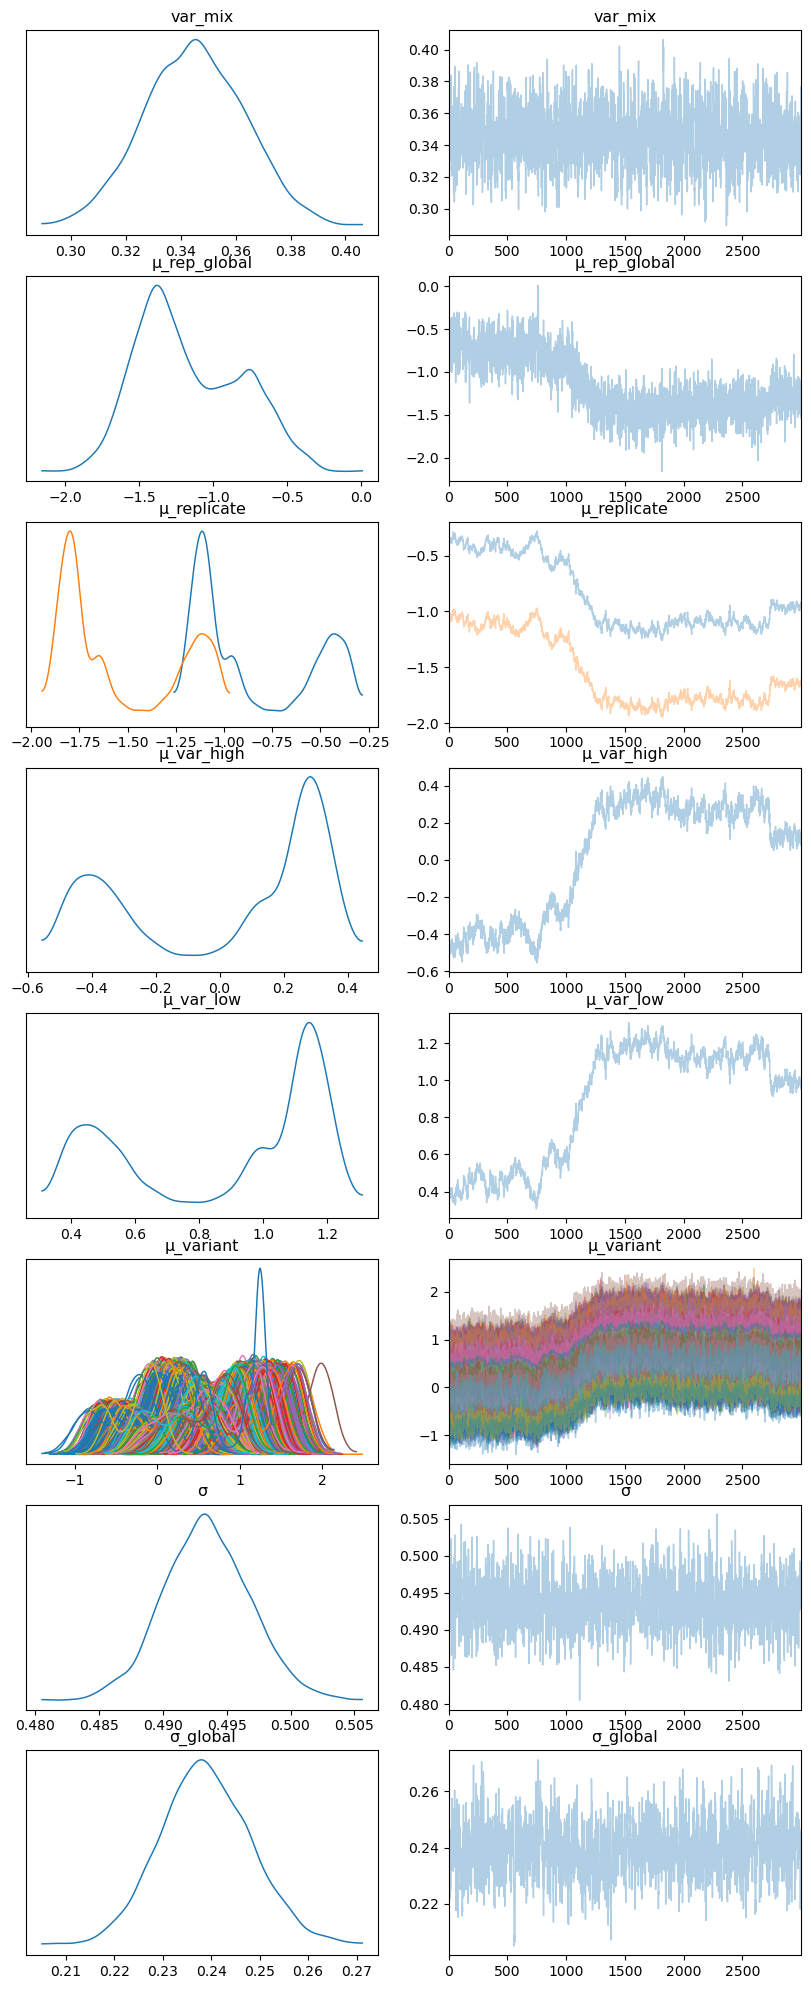

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var_mix,0.345,0.018,0.310,0.377,0.001,0.000,1004.0,1024.0,NaN
μ_rep_global,-1.162,0.351,-1.716,-0.523,0.273,0.244,2.0,14.0,NaN
μ_replicate[0],-0.854,0.313,-1.189,-0.337,0.265,0.254,2.0,21.0,NaN
μ_replicate[1],-1.541,0.313,-1.883,-1.031,0.266,0.255,2.0,20.0,NaN
μ_var_high,0.024,0.314,-0.484,0.380,0.265,0.253,2.0,22.0,NaN
...,...,...,...,...,...,...,...,...,...
μ_variant[1018],-0.320,0.335,-0.913,0.168,0.269,0.246,2.0,13.0,NaN
μ_variant[1019],0.257,0.357,-0.394,0.804,0.278,0.249,2.0,13.0,NaN
μ_variant[1020],0.987,0.313,0.475,1.332,0.266,0.255,2.0,20.0,NaN
σ,0.493,0.003,0.487,0.500,0.000,0.000,1424.0,1458.0,NaN


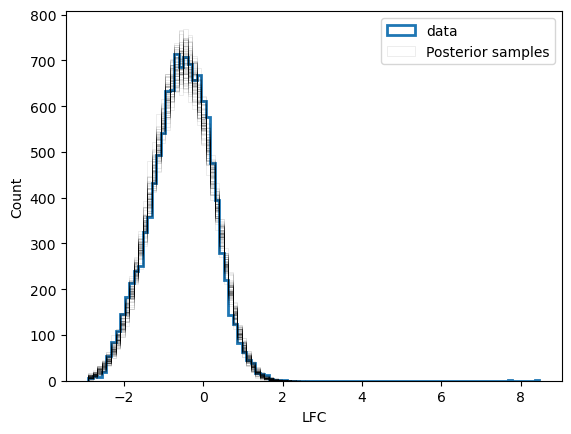

In [24]:
def model_rep_mix_variant(variant_code, replicate_code, LFC_obs=None):
    σ_global = numpyro.sample("σ_global", dist.HalfNormal(1.0))


    μ_var_high = numpyro.sample("μ_var_high", dist.Normal(0.0, 0.5))
    μ_var_low = numpyro.sample("μ_var_low", dist.Normal(-1.0, 0.5))
    var_mix = numpyro.sample("var_mix", dist.Uniform(0.0, 1.0))

    n_variants = len(np.unique(variant_code))
    variant_plate = numpyro.plate("plate_variant", n_variants)
    with variant_plate:
        variant_mixing_dist = dist.MixtureGeneral(dist.Categorical(probs=jnp.stack((var_mix, 1 - var_mix), axis=-1)), 
                                                  [dist.Normal(μ_var_high, σ_global),
                                                   dist.Normal(μ_var_low, σ_global)])
        
        μ_variant = numpyro.sample(
            "μ_variant",
            variant_mixing_dist,
        )

    μ_rep_global = numpyro.sample("μ_rep_global", dist.Normal(0.0, 1.0))
    n_replicates = len(np.unique(replicate_code))
    replicate_plate = numpyro.plate('plate_replicate', n_replicates)
    with replicate_plate:
        μ_replicate = numpyro.sample(
            "μ_replicate",
            dist.Normal(μ_rep_global, σ_global),
        )



    σ = numpyro.sample("σ", dist.HalfNormal(1.0))
    LCF_est = μ_variant[variant_code] + μ_replicate[replicate_code]
    
    with numpyro.plate("data", len(variant_code)):
        numpyro.sample("LFC", dist.Normal(LCF_est, σ), obs=LFC_obs)

infered, summary = run_inference(model_rep_mix_variant, map_measurement_to_variant, df.replicate_code.values, kernel=NUTS(model_rep_mix_variant), LFC_obs = df.LFC.values)

In [14]:
df_direct = pd.read_excel('../23.06.29_new_library_design/2024_01_19_experimental_results/DSM_results.xlsx')[['annotation', 'Rep1 P0','Rep1 P10','Rep2 P0','Rep2 P10']]
df_direct = df_direct.rename(columns={'Rep1 P0':'P0-1','Rep1 P10':'P10-1','Rep2 P0':'P0-2','Rep2 P10':'P10-2'}).dropna()
df_direct = pd.wide_to_long(df_direct, ['P0', 'P10'], 'annotation', 'replicate', sep='-').reset_index()
annotations = df.annotation.str.split('_',expand=True)
annotations = annotations.rename(columns={0:'mut_number', 1:'variant', 2:'version'})
df_direct = pd.concat([df_direct, annotations], axis='columns').dropna()
split_names = df_direct.annotation.str.extract('pt_(?P<position>\d*)(?P<AA>[a-zA-Z\*]*)')
split_names.index = df_direct.index
df_direct = pd.concat([df_direct, split_names], axis='columns').dropna()

replicate_encoder = LabelEncoder()
df_direct["replicate_code"] = replicate_encoder.fit_transform(df_direct["replicate"].values)

variant_encoder = LabelEncoder()
df_direct["variant_code"] = variant_encoder.fit_transform(df_direct["variant"].values)

df_direct

,annotation,replicate,P0,P10,mut_number,variant,version,position,AA,replicate_code,variant_code
0,0pt_WT_v1,1.0,5176.0,2982.0,0pt,WT,v1,,WT,0,1020
1,0pt_WT_v10,1.0,5634.0,4139.0,0pt,WT,v10,,WT,0,1020
2,0pt_WT_v100,1.0,8720.0,5459.0,0pt,WT,v100,,WT,0,1020
3,0pt_WT_v101,1.0,3598.0,1664.0,0pt,WT,v101,,WT,0,1020
4,0pt_WT_v102,1.0,5589.0,3777.0,0pt,WT,v102,,WT,0,1020
...,...,...,...,...,...,...,...,...,...,...,...
11971,1pt_51Y_v1,2.0,907.0,1347.0,1pt,51W,v5,51,Y,1,1018
11972,1pt_51Y_v2,2.0,2054.0,1246.0,1pt,51Y,v1,51,Y,1,1019
11973,1pt_51Y_v3,2.0,3399.0,1343.0,1pt,51Y,v2,51,Y,1,1019
11974,1pt_51Y_v4,2.0,2789.0,2210.0,1pt,51Y,v3,51,Y,1,1019


<AxesSubplot: xlabel='P0', ylabel='Count'>

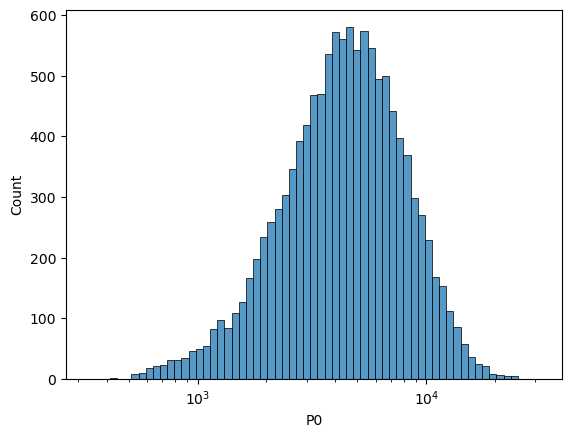

In [18]:
sns.histplot(df_direct, x='P0',log_scale=True)

<AxesSubplot: xlabel='P10', ylabel='Count'>

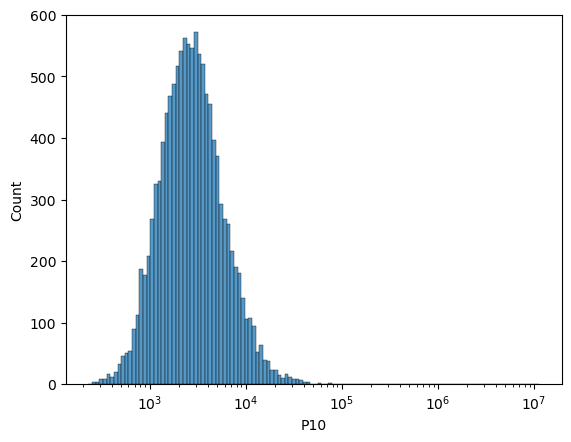

In [17]:
sns.histplot(df_direct, x='P10', log_scale=True)

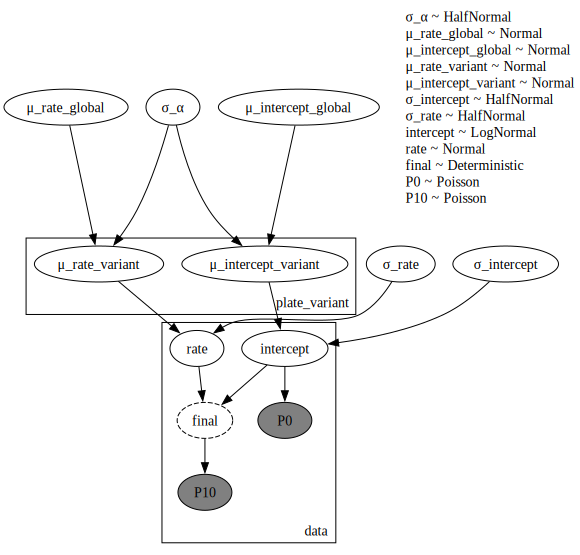

/Users/jackdesmarais/miniconda3/envs/Vakoc_library_analysis/lib/python3.9/site-packages/numpy/core/function_base.py:431: RuntimeWarning: invalid value encountered in log10
  log_start = _nx.log10(start)


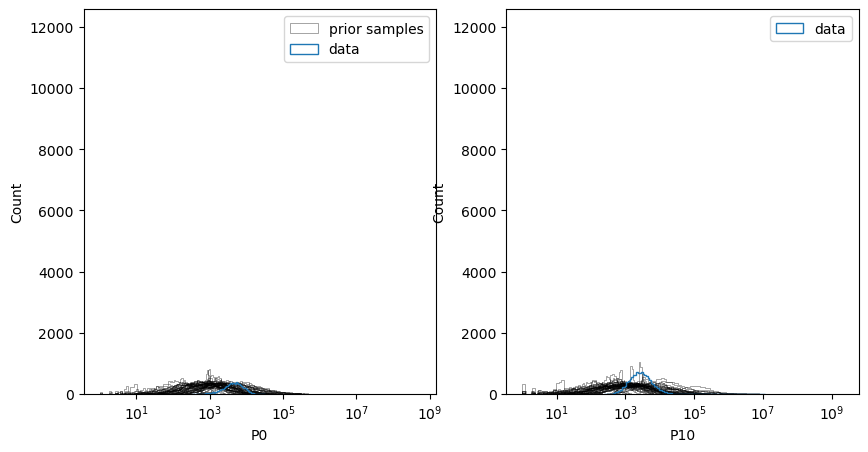

Array([4146024105,  967050713], dtype=uint32)

In [53]:
def model_direct_variant(variant_code, P0_obs=None, P10_obs=None):
    σ_global = numpyro.sample("σ_α", dist.HalfNormal(1.0))

    μ_rate_global = numpyro.sample("μ_rate_global", dist.Normal(0.0, 0.1))
    μ_intercept_global = numpyro.sample("μ_intercept_global", dist.Normal(7, 1.0))


    n_variants = len(np.unique(variant_code))

    with numpyro.plate("plate_variant", n_variants):
        μ_rate_variant = numpyro.sample(
            "μ_rate_variant",
            dist.Normal(μ_rate_global, σ_global),
        )

        μ_intercept_variant = numpyro.sample(
            "μ_intercept_variant",
            dist.Normal(μ_intercept_global, σ_global),
        )

    σ_intercept = numpyro.sample("σ_intercept", dist.HalfNormal(1.0))
    σ_rate = numpyro.sample("σ_rate", dist.HalfNormal(0.01))
    μ_intercept = μ_intercept_variant[variant_code]
    μ_rate = μ_rate_variant[variant_code]


    
    with numpyro.plate("data", len(variant_code)):
        intercept = numpyro.sample("intercept", dist.LogNormal(μ_intercept, σ_intercept))
        rate = numpyro.sample("rate", dist.Normal(μ_rate, σ_rate))

        final = numpyro.deterministic('final',intercept*jnp.exp(rate))

        numpyro.sample('P0', dist.Poisson(intercept),obs = P0_obs)
        numpyro.sample('P10', dist.Poisson(final),obs = P10_obs)


plot_prior(model_direct_variant, df_direct.variant_code.values, 
           log_scale=True,
           P0_obs=df_direct['P0'].values,
           P10_obs=df_direct['P10'].values,
           plot_vars = {'P0':'P0_obs', 'P10':'P10_obs'})

# infered, summary = run_inference(model_direct_variant, df_direct.variant_code.values, 
#                                  kernel=NUTS(model_direct_variant), 
#                                  P0_obs=df_direct['P0'].values, P10_obs=df_direct['P10'].values,
#                                  plot_vars = {'P0':'P0_obs', 'P10':'P10_obs'})

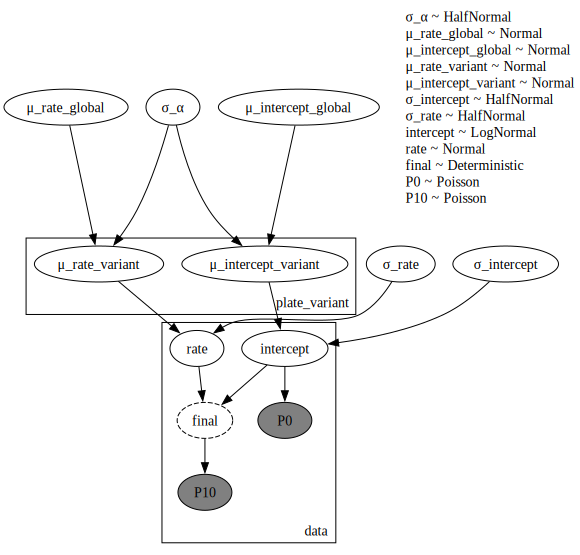

/Users/jackdesmarais/miniconda3/envs/Vakoc_library_analysis/lib/python3.9/site-packages/numpy/core/function_base.py:431: RuntimeWarning: invalid value encountered in log10
  log_start = _nx.log10(start)


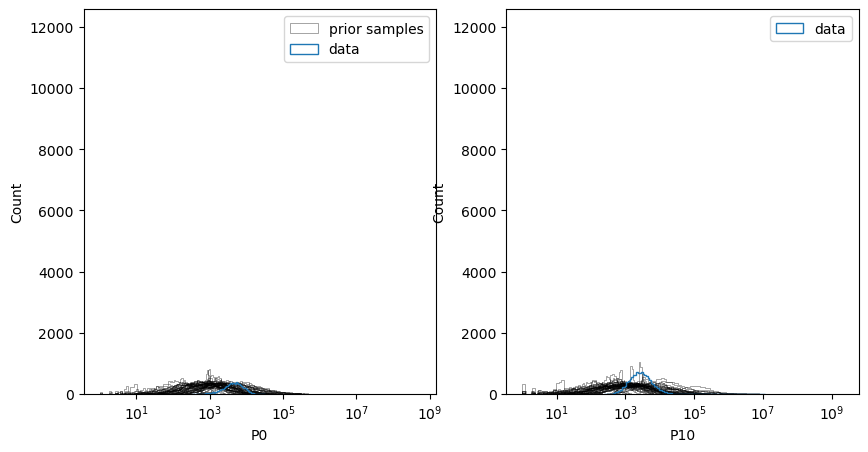

sample: 100%|██████████| 8000/8000 [1:27:47<00:00,  1.52it/s, 1023 steps of size 2.72e-06. acc. prob=0.83]
/Users/jackdesmarais/miniconda3/envs/Vakoc_library_analysis/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/jackdesmarais/miniconda3/envs/Vakoc_library_analysis/lib/python3.9/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: divide by zero encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/jackdesmarais/miniconda3/envs/Vakoc_library_analysis/lib/python3.9/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: invalid value encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/jackdesmarais/miniconda3/envs/Vakoc_library_analysis/lib/python3.9/site-packages/arviz/stats/density_utils.py:699: RuntimeWarning: divide by zero encou

OverflowError: cannot convert float infinity to integer

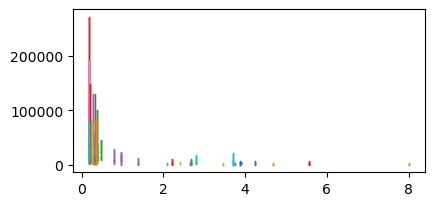

In [55]:
infered, summary = run_inference(model_direct_variant, df_direct.variant_code.values, 
                                 kernel=NUTS(model_direct_variant), 
                                 log_scale=True,
                                 P0_obs=df_direct['P0'].values, P10_obs=df_direct['P10'].values,
                                 plot_vars = {'P0':'P0_obs', 'P10':'P10_obs'})